## load libraries

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd

In [4]:
sys.path.insert(0, "../")
from utils.DLutils import *
from utils.vizutils import *

In [5]:
DEEPREPVIZ_REPO = os.path.abspath("../../Deep-confound-control-v2/")
if DEEPREPVIZ_REPO not in sys.path: sys.path.append(DEEPREPVIZ_REPO)

from DeepRepVizBackend import DeepRepVizBackend

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## DeepRepVizBackend

### Init DeepRepVizBackend using the attributes table

In [6]:
DATASET_UNIQUE_ID = 't2'
attributes_table = f"../dataset/toybrains_n10000_lblmidr_covsite_{DATASET_UNIQUE_ID}/toybrains_n10000_lblmidr_covsite_{DATASET_UNIQUE_ID}.csv"
df_attrs = pd.read_csv(attributes_table)
# print(df_attrs.columns)
ID_col = 'subjectID'
label = 'lbl_lesion'

In [7]:
drv_backend = DeepRepVizBackend(        
                  conf_table=df_attrs,
                  ID_col=ID_col, label_col=label,
                  best_ckpt_by='loss', best_ckpt_metric_should_be='min',
                  debug=True)

[log] Potential Confounders to be assessed:
[log] 	 cov_site                   predtype: classif_binary    uniques = {'siteB': 5051, 'siteA': 4949}
[log] 	 lbl_lesion                 predtype: classif_binary    uniques = {True: 5012, False: 4988}
[log] 	 brain-int_border           predtype: classif           uniques = {'1-slateblue': 2519, '3-darkblue': 2516, '2-darkslateblue': 2485, '0-mediumslateblue': 2480}
[log] 	 brain-int_fill             predtype: regression        
[log] 	 brain-vol_radmajor         predtype: regression        
[log] 	 brain-vol_radminor         predtype: regression        
[log] 	 brain_thick                predtype: regression        
[log] 	 shape-botl_curv            predtype: regression        
[log] 	 shape-botl_int             predtype: classif           uniques = {'2-lightsalmon': 1714, '5-darkgreen': 1696, '4-lightgreen': 1690, '0-indianred': 1665, '1-salmon': 1621, '3-palegoldenrod': 1614}
[log] 	 shape-botl_vol-rad         predtype: regression       

In [8]:
# Make a list of all models (different model architecture or different runs/versions of the same model architecture)
# trained on the current dataset
logdirs = sorted([logdir for logdir in glob(f"log/toybrains-{DATASET_UNIQUE_ID}*/*/deeprepvizlog/") if 'debug' not in logdir])
logdirs

['log/toybrains-t2_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/',
 'log/toybrains-t2_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/']

### Load the trained model log dirs

In [9]:
# load all of the models' logs one by one
for logdir in logdirs:
    drv_backend.load_log(logdir)

In [10]:
# the logs are loaded in drv_backend.deeprepvizlogs
drv_backend._pprint_deeprepvizlogs()

----------------------------------------------------------------------------------------------------
DeepRepViz log no.1: 
log/toybrains-t2_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/
	n(samples)        : 10000
	IDs               : [2579 7128 4082] ... [7853 1095 6929]
	labels            : [False  True  True] ... [False  True  True]
	n(checkpoints)    : 50
			   Each checkpoint has the following data: 
			   acts.shape : (10000, 3)
			   acts_3D.shape : (10000, 3)
			   preds_0.shape : (10000,)
			   metrics : <class 'dict'> | keys: ['loss', 'BAC', 'D2']
			   weights_0 : <class 'list'> | len: 3
			   biases_0 : <class 'float'> 
			   act_metrics : <class 'dict'> | keys: ['dcor', 'mi', 'con', 'costeta', 'r2']
	best checkpoint   : best_ckpt_idx = 49 	 name = epoch49-step002500
			   {'loss': '0.50', 'BAC': '0.77', 'D2': '0.28'}

	attributes table  : shape = (10000, 29)
			   ID_col = subjectID 	 label_col = lbl_lesion  	 n(attrs cols) = 28
			   attrs = ['cov_site', 'brain-int_border',

### downsample the activations to 3D

In [11]:
# downsample the activations to 3D if not already done
drv_backend.downsample_activations()

/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:192: UserWarning: The activations have already been reduced to 3D for log/toybrains-t2_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/ and saved in tensors_3D.tsv. Overwriting these...
  warnings.warn(f"The activations have already been reduced to 3D for {log_key} and saved in tensors_3D.tsv.\


Reducing activations to 3D using PCA


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]
/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:192: UserWarning: The activations have already been reduced to 3D for log/toybrains-t2_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/ and saved in tensors_3D.tsv. Overwriting these...
  warnings.warn(f"The activations have already been reduced to 3D for {log_key} and saved in tensors_3D.tsv.\
100%|██████████| 45/45 [00:04<00:00,  9.32it/s]


### Create DeepRepViz v1 frontend csv

In [12]:
# you can also ask the backend to create a table compatible with the DeepRepViz v1 frontend for each log individually
for logdir in logdirs:
    # internally this will also downsample the activations to 3D using PCA and save them in deeprepvizlogs
    df = drv_backend.convert_log_to_v1_table(log_key=logdir, 
                                             unique_name=logdir.split('/')[-4])

/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:297: UserWarning: The file log/toybrains-t2_SimpleCNN_cls1-fea3/version_0/deeprepvizlog//DeepRepViz-v1-toybrains-t2_SimpleCNN_cls1-fea3.csv already exists. Overwriting it...
  warnings.warn(f"The file {v1_table_path} already exists. Overwriting it...")
100%|██████████| 50/50 [00:02<00:00, 17.81it/s]
/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:297: UserWarning: The file log/toybrains-t2_SimpleCNN_cls1-fea64/version_0/deeprepvizlog//DeepRepViz-v1-toybrains-t2_SimpleCNN_cls1-fea64.csv already exists. Overwriting it...
  warnings.warn(f"The file {v1_table_path} already exists. Overwriting it...")
100%|██████████| 45/45 [00:02<00:00, 17.82it/s]


### Compute metrics

In [24]:
# The backend can be asked to compute metrics for specific logdirs in the deeprepvizlogs
drv_backend.debug = False
for i, logdir in enumerate(logdirs):
    # you can first verify check if the metrics have been computed and stored already 
    metrics = ['dcor', 'mi', 'con', 'costeta', 'r2']
    existing_metrics = drv_backend.get_metrics(logdir, ckpt_idx='best')
    if existing_metrics is not None:
        metrics = [m for m in metrics if m not in existing_metrics]
        print(f"Skipping {list(existing_metrics.keys())} for {logdir}. As they have already been computed.")

    # it will compute it and store it in the metametadata.json file of the logdirs
    if len(metrics) > 0:
        result = drv_backend.compute_metrics(log_key=logdir,
                                             metrics=metrics,
                                            #   covariates=['lbl_lesion','cov_site', 'brain-int_fill','shape-midr_curv', 'shape-midr_vol-rad'], 
                                             ckpt_idx='best')
    # the computed metrics is also additionally returned as a dictionary
    # display(result)

Skipping ['dcor', 'mi', 'con', 'costeta', 'r2'] for log/toybrains-t2_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/. As they have already been computed.
Skipping ['dcor', 'mi', 'con', 'costeta', 'r2'] for log/toybrains-t2_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/. As they have already been computed.


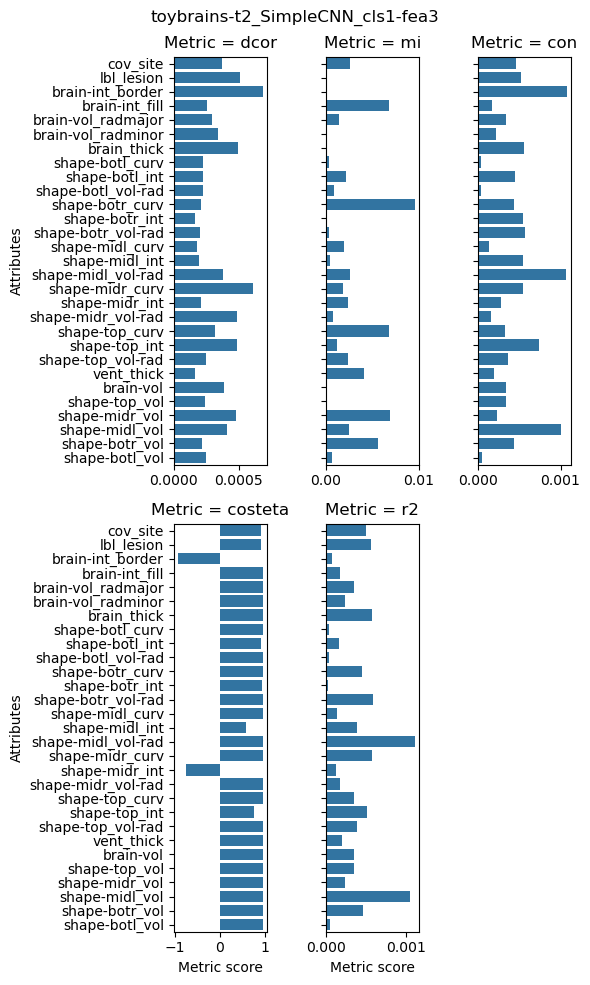

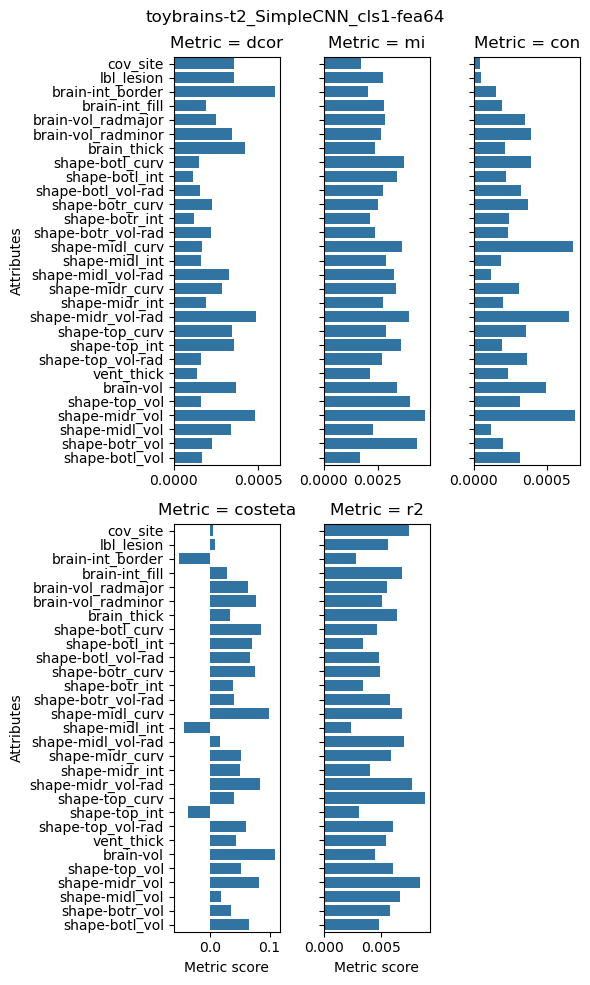

In [25]:
# get all the computed metrics as a dict
for i, logdir in enumerate(logdirs):
    scores = drv_backend.get_metrics(logdir, ckpt_idx='best')
    viz_rep_metrics(scores, title=f"{logdir.split('/')[-4]}")

#### IMPORTANT NOTE FOR DeepRepViz devs
The main purpose of the DeepRepViz tool is to perform the above visualizations interactively (without the need to explicitly code them) in conjuncture with the 3D representations itself.

DeepRepViz tool would allow us not only to
1. compare across multiple metrics at the same time, but also,
2. compare how these metrics evolve across the epochs
3. compare how these metrics are for activations from different layers of the same model
4. Compare across multiple models that can be tested on the same data

The main power of DeepRepViz would be in enabling the researchers to gain an intuition about the learned representation (activations shown as 3D plots). We can be further enabled by adding vectorial interpretation features to the 3D representation space as provided by[this tool](https://adrijanik.github.io/concepts-vis/) or by the [tensorflow's embedding projector](https://projector.tensorflow.org/). Such interactive vectorial interpretations would be particularly useful with methods such as [Concept Activation Vectors](https://arxiv.org/abs/1711.11279). 


### Run the above for all other dataset variations
you can prepare a python script similar to 

```bash
python3 lbl1cov1_3-backend.py
```

The results will be updated within the `deeprepvizlog` files

## Summarize all results

In [38]:
all_results = {}
logdirs = sorted([log for log in glob(f"log/toybrains-t*/*/deeprepvizlog/") if 'debug' not in log])

for logdir in logdirs:
    print("loading:", logdir)
    drv_backend = DeepRepVizBackend()
    drv_backend.load_log(logdir)
    log = drv_backend.deeprepvizlogs[logdir]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    logdirname = logdir.split('/')[-4].replace('toybrains-','')
    # print('='*100,'\n', method_name, "at ckpt =", ckptname)
    # print(log.keys())
    # print("Model accuracy =", log_ckpt['metrics']) 
    result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
    for metric_name, metric_scores in log_ckpt['act_metrics'].items():
        # print('-'*100,"\nMetric =", metric_name, '\n', '-'*100,)
        for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
            result.update({(key, metric_name): metric_scores[key]})
            # print("{} = {:.4f}".format(key, metric_scores[key]))

    all_results.update({logdirname: result})

df_results = pd.DataFrame.from_dict(all_results, orient='index')
# sort the dataframe by the two levels of column headers
df_results = df_results.sort_index(axis=1, level=[0,1])
df_results.style.bar()


loading: log/toybrains-t0_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t0_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t1_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t1_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t2_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t2_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t3_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t3_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t4_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


loading: log/toybrains-t4_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/


/ritter/roshan/workspace/Deep-confound-control-v2/DeepRepVizBackend.py:32: UserWarning: conf_table provided None is neither a pandas Dataframe nor a path to a table.Skipping all conf_table operations
  raise ValueError(f"conf_table provided {conf_table} is neither a pandas Dataframe nor a path to a table.")


#### test with a different 3D dimensionality reduction method?

In [ ]:
# dim_reduct_method = TSNE(n_components=3, learning_rate='auto',
#                          init='random', perplexity=3) 

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./log/lightning_logs/
# !kill -9 1237900

#### Calculate other backend metrics ?